# Reattempt for GA with Options Strategy


In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from requests import get
from retry import retry
import scipy.stats as stats
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from datetime import datetime

BROKER_URL = 'http://localhost:4003/'


def black_scholes_greeks(S, K, T, r, sigma, option_type):
    """
    Calculates option Greeks using the Black-Scholes model.

    Args:
        S: Current underlying asset price
        K: Strike price
        T: Time to expiration (in years)
        r: Risk-free interest rate
        sigma: Volatility of the underlying asset
        option_type: 'Call' or 'Put'

    Returns:
        A dictionary containing the following Greeks:
            delta: Change in option price w.r.t. underlying price
            gamma: Change in delta w.r.t. underlying price
            vega: Change in option price w.r.t. volatility
            theta: Change in option price w.r.t. time
            rho: Change in option price w.r.t. interest rate
    """

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'Call':
        N_d1 = stats.norm.cdf(d1)
        N_d2 = stats.norm.cdf(d2)
        delta = N_d1
        gamma = stats.norm.pdf(d1) / (S * sigma * np.sqrt(T))
        vega = S * stats.norm.pdf(d1) * np.sqrt(T)
        theta = -(S * stats.norm.pdf(d1) * sigma) / \
            (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * N_d2
        rho = K * T * np.exp(-r * T) * N_d2
    elif option_type == 'Put':
        N_d1 = stats.norm.cdf(-d1)
        N_d2 = stats.norm.cdf(-d2)
        delta = -N_d1
        gamma = stats.norm.pdf(d1) / (S * sigma * np.sqrt(T))
        vega = S * stats.norm.pdf(d1) * np.sqrt(T)
        theta = -(S * stats.norm.pdf(d1) * sigma) / \
            (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * N_d2
        rho = -K * T * np.exp(-r * T) * N_d2
    else:
        raise ValueError(
            "Invalid option type. Please specify 'Call' or 'Put'.")

    return {
        'delta': delta,
        'gamma': gamma,
        'vega': vega,
        'theta': theta,
        'rho': rho
    }


def black_scholes_price(S, K, T, r, sigma, option_type):
    """Calculates the Black-Scholes option price."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'Call':
        price = S * stats.norm.cdf(d1) - K * \
            np.exp(-r * T) * stats.norm.cdf(d2)
    elif option_type == 'Put':
        price = K * np.exp(-r * T) * stats.norm.cdf(-d2) - \
            S * stats.norm.cdf(-d1)
    else:
        raise ValueError(
            "Invalid option type. Please specify 'Call' or 'Put'.")
    return price


def implied_volatility(
    S,
    K,
    T,
    r,
    market_price,
    option_type,
    tol=1e-6,
    max_iter=100
):
    """Calculates implied volatility using the Newton-Raphson method."""
    sigma = 0.2  # Initial guess for volatility
    for i in range(max_iter):
        price = black_scholes_price(S, K, T, r, sigma, option_type)
        vega = black_scholes_greeks(S, K, T, r, sigma, option_type)['vega']
        if vega == 0:
            continue
        sigma_new = sigma - (price - market_price) / vega
        if np.abs(sigma_new - sigma) < tol:
            break
        sigma = sigma_new
    else:
        raise ValueError(
            f"Failed to converge within tolerance., {np.abs(sigma_new - sigma)}, {tol}"
        )
    return sigma_new


def get_option_chain(symbol, right, wte):
    sub_url = f"option_chain/{symbol}/{right}/{wte}"
    resp = get(BROKER_URL + sub_url)
    return resp.json()


@retry(tries=3, delay=1, backoff=2)
def get_option_history(symbol, right, wte, strike_price, hist_date):
    options = {
        'right': right,
        'wte': wte,
        'strike_price': strike_price,
        'product_type': 'options',
        'exchange_code': 'NFO',
    }
    options_str = '&'.join([f"{k}={v}" for k, v in options.items()])
    sub_url = f"history/{symbol}/{hist_date}?{options_str}"
    resp = get(BROKER_URL + sub_url)
    return resp.json()

{'delta': -0.6495118413812125,
 'gamma': 0.00035272796043169457,
 'vega': 1008.5048239102462,
 'theta': -11989.75398453419,
 'rho': -227.37317566303133}

In [19]:


rcall = get_option_chain('NIFTY', 'Call', 1)
rput = get_option_chain('NIFTY', 'Put', 1)

oc_df = pd.concat(
    [
        pd.DataFrame(rcall['Success']),
        pd.DataFrame(rput['Success'])
    ]
)
oc_df['strike_distance'] = ((oc_df['spot_price'].astype(
    np.float64) - oc_df['strike_price'].astype(np.float64))//50).abs()

oc_df[oc_df['strike_distance'] <= 10].sort_values(
    ['right', 'strike_price']).reset_index(drop=True)

,exchange_code,product_type,stock_code,expiry_date,right,strike_price,ltp,ltt,best_bid_price,best_bid_quantity,...,upper_circuit,lower_circuit,total_quantity_traded,spot_price,ltq,open_interest,chnge_oi,total_buy_qty,total_sell_qty,strike_distance
0,NFO,Options,NIFTY,02-May-2024,Call,21600.0,652.20,19-Apr-2024 15:29:30,652.80,400,...,1088.40,222.30,51400,22147,200,13950.0,0.0,8650,4700,10.0
1,NFO,Options,NIFTY,02-May-2024,Call,21650.0,606.80,19-Apr-2024 15:27:18,609.55,400,...,1034.70,189.90,44050,22147,100,7950.0,0.0,11400,5400,9.0
2,NFO,Options,NIFTY,02-May-2024,Call,21700.0,570.00,19-Apr-2024 15:29:30,567.70,400,...,987.10,165.60,196850,22147,100,23000.0,0.0,15700,6500,8.0
3,NFO,Options,NIFTY,02-May-2024,Call,21750.0,527.70,19-Apr-2024 15:29:23,525.70,400,...,928.75,132.55,82750,22147,50,14000.0,0.0,16500,8100,7.0
4,NFO,Options,NIFTY,02-May-2024,Call,21800.0,486.90,19-Apr-2024 15:29:53,484.30,50,...,881.15,112.15,1150600,22147,100,165450.0,0.0,17400,11500,6.0
5,NFO,Options,NIFTY,02-May-2024,Call,21850.0,445.70,19-Apr-2024 15:29:45,445.85,950,...,823.55,83.65,492750,22147,100,28350.0,0.0,11100,7750,5.0
6,NFO,Options,NIFTY,02-May-2024,Call,21900.0,410.00,19-Apr-2024 15:29:53,407.80,1000,...,772.25,63.05,1783200,22147,50,176000.0,0.0,15050,10100,4.0
7,NFO,Options,NIFTY,02-May-2024,Call,21950.0,370.15,19-Apr-2024 15:29:50,370.30,800,...,718.55,41.55,404800,22147,150,34400.0,0.0,11300,8750,3.0
8,NFO,Options,NIFTY,02-May-2024,Call,22000.0,330.30,19-Apr-2024 15:29:54,335.00,1050,...,671.40,27.80,4019100,22147,50,519200.0,0.0,34450,15150,2.0
9,NFO,Options,NIFTY,02-May-2024,Call,22050.0,305.00,19-Apr-2024 15:29:59,300.00,50,...,615.00,5.90,526800,22147,50,44350.0,0.0,14500,4800,1.0


In [ ]:
odf = oc_df[oc_df['strike_distance'] <= 10].sort_values(
    'strike_price')[['stock_code', 'right', 'strike_price']].reset_index(drop=True)

WTE = 0

hist_dfs = []
for record in odf.to_dict('records'):
    resp = get_option_history(
        'NIFTY',
        record['right'],
        WTE,
        int(record['strike_price']),
        '20240419'
    )
    if resp['Error']:
        continue
    hist_df = pd.DataFrame(resp['Success'])
    hist_df['stock_code'] = record['stock_code']
    hist_dfs.append(hist_df)

hist_df = pd.concat(hist_dfs)

ndf = pd.read_csv('/workspace/nifty/NIFTY/20240419.csv',
                  parse_dates=['datetime']).set_index('datetime')

In [20]:
len(hist_dfs)

42

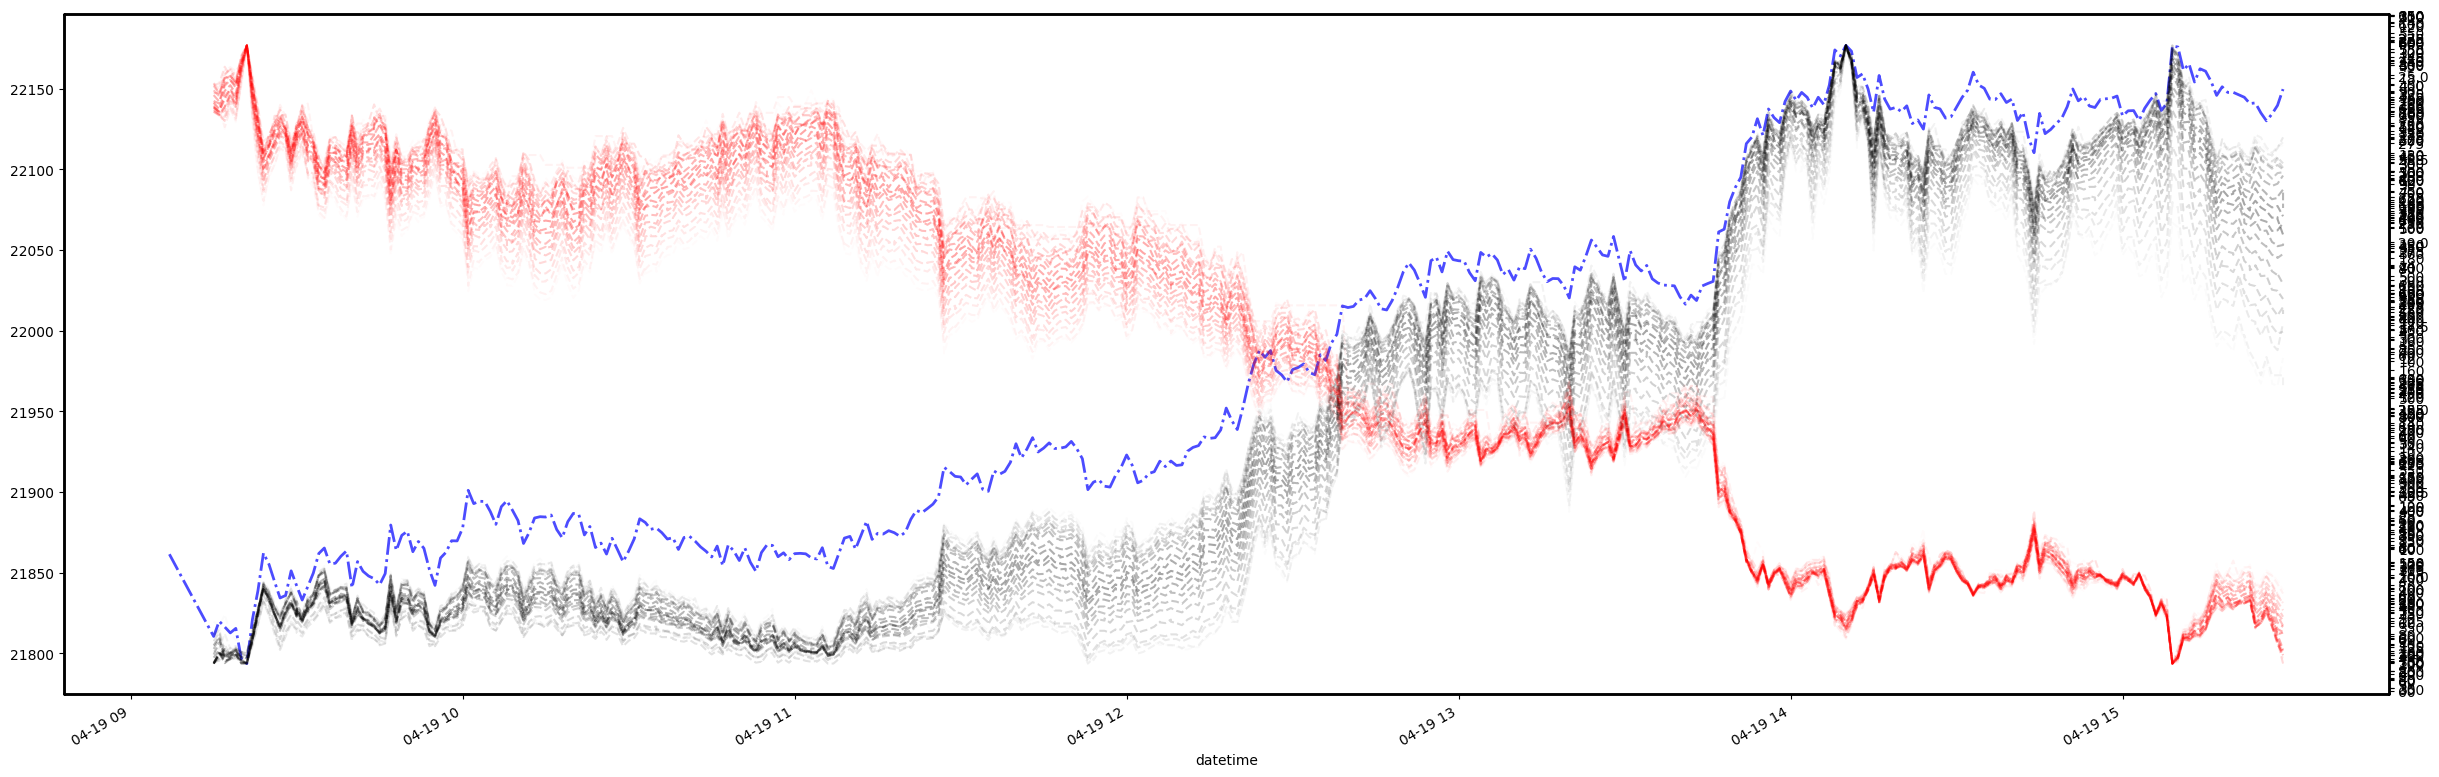

In [8]:

fig, ax = plt.subplots(1, 1, figsize=(30, 10))
spot = oc_df.spot_price.astype(np.float64).unique()[0]
for hist_df in hist_dfs:
    strike = hist_df['strike_price'].astype(np.float64).unique()[0]
    right = hist_df['right'].unique()[0]

    dist = np.abs((spot - strike)//50)/30
    hist_df['datetime'] = pd.to_datetime(hist_df['datetime'])
    hist_df.set_index('datetime')['close'].plot(
        ax=ax.twinx(), c='k' if right == 'Call' else 'r', alpha=.35-dist, ls='--')

ndf['close'].plot(ax=ax, c='b', alpha=.7, ls='-.', lw=2)
plt.show()

In [21]:
time_offset = 150

curr_date = ndf.index[time_offset]
hist_df = pd.concat(hist_dfs)
hist_df.expiry_date = pd.to_datetime(hist_df.expiry_date)

expiry_date = hist_df.expiry_date.unique()[0]

days_to_expiry = (expiry_date - curr_date).days + \
    (expiry_date - curr_date).seconds / (3600*24)

T = days_to_expiry / 365
r = 0.06

In [60]:
S = 22147
K = 21600
sigma = 0.2
option_type = 'Call'


def black_scholes_greeks(S, K, T, r, sigma, option_type):
    """
    Calculates option Greeks using the Black-Scholes model.

    Args:
        S: Current underlying asset price
        K: Strike price
        T: Time to expiration (in years)
        r: Risk-free interest rate
        sigma: Volatility of the underlying asset
        option_type: 'Call' or 'Put'

    Returns:
        A dictionary containing the following Greeks:
            delta: Change in option price w.r.t. underlying price
            gamma: Change in delta w.r.t. underlying price
            vega: Change in option price w.r.t. volatility
            theta: Change in option price w.r.t. time
            rho: Change in option price w.r.t. interest rate
    """

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'Call':
        N_d1 = stats.norm.cdf(d1)
        N_d2 = stats.norm.cdf(d2)
        delta = N_d1
        gamma = stats.norm.pdf(d1) / (S * sigma * np.sqrt(T))
        vega = S * stats.norm.pdf(d1) * np.sqrt(T)
        theta = -(S * stats.norm.pdf(d1) * sigma) / \
            (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * N_d2
        rho = K * T * np.exp(-r * T) * N_d2
    elif option_type == 'Put':
        N_d1 = stats.norm.cdf(-d1)
        N_d2 = stats.norm.cdf(-d2)
        delta = -N_d1
        gamma = stats.norm.pdf(d1) / (S * sigma * np.sqrt(T))
        vega = S * stats.norm.pdf(d1) * np.sqrt(T)
        theta = -(S * stats.norm.pdf(d1) * sigma) / \
            (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * N_d2
        rho = -K * T * np.exp(-r * T) * N_d2
    else:
        raise ValueError(
            "Invalid option type. Please specify 'Call' or 'Put'.")

    return {
        'delta': delta,
        'gamma': gamma,
        'vega': vega,
        'theta': theta,
        'rho': rho
    }


def black_scholes_price(S, K, T, r, sigma, option_type):
    """Calculates the Black-Scholes option price."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'Call':
        price = S * stats.norm.cdf(d1) - K * \
            np.exp(-r * T) * stats.norm.cdf(d2)
    elif option_type == 'Put':
        price = K * np.exp(-r * T) * stats.norm.cdf(-d2) - \
            S * stats.norm.cdf(-d1)
    else:
        raise ValueError(
            "Invalid option type. Please specify 'Call' or 'Put'.")
    return price


def implied_volatility(
    S,
    K,
    T,
    r,
    market_price,
    option_type,
    tol=1e-6,
    max_iter=100
):
    """Calculates implied volatility using the Newton-Raphson method."""
    sigma = .5  # Initial guess for volatility
    for i in range(max_iter):
        price = black_scholes_price(S, K, T, r, sigma, option_type)
        vega = black_scholes_greeks(S, K, T, r, sigma, option_type)['vega']
        if vega == 0:
            continue
        sigma_new = sigma - (price - market_price) / vega
        print(price, vega, sigma, market_price, np.abs(sigma_new - sigma))
        if np.abs(sigma_new - sigma) < tol:
            break
        sigma = sigma_new
    else:
        raise ValueError(
            f"Failed to converge within tolerance., {np.abs(sigma_new - sigma)}, {tol}"
        )
    return sigma_new


# black_scholes_greeks(S, K, T, r, sigma, option_type)
implied_volatility(S, K, T, r, sigma, option_type)

866.0383746846674 980.0152344418309 0.5 0.2 0.8834948113615875
-188.31766020166015 921.0395102439235 -0.3834948113615875 0.2 0.2046792326549966
-28.10587036382458 534.5493553504499 -0.17881557870659087 0.2 0.05295277242504068
-6.560107825975933 263.25355614418845 -0.1258628062815502 0.2 0.02567907505216495
-1.7163488407288696 116.88934368997442 -0.10018373122938524 0.2 0.016394555570536873
-0.42788913615160595 45.11966234312244 -0.08378917565884837 0.2 0.013916086768927569
-0.06723055147885049 11.26742573689863 -0.0698730888899208 0.2 0.023717090107256922
-6.119675360648918e-05 0.03136685125657432 -0.04615599878266388 0.2 6.378109014422504
6905.8912960598445 993.0389111253335 6.33195301563984 0.2 6.954099400026696
-421.2830315311121 1011.1161577134548 -0.6221463843868555 0.2 0.4168492693107158
-43.60815267466296 632.2356913252609 -0.20529711507613974 0.2 0.06929085667851889
-9.530149124374248 322.04916722227046 -0.13600625839762084 0.2 0.03021324106594797
-2.4553553428324335 146.930605

ValueError: Failed to converge within tolerance., 0.0, 1e-06

In [47]:
hist_df[
    (hist_df['datetime'] == ndf.index[time_offset])
    & (hist_df['strike_price'] == 22100.0)
]

,close,datetime,exchange_code,expiry_date,high,low,open,open_interest,product_type,right,stock_code,strike_price,volume
261,260.55,2024-04-19 11:44:00,NFO,2024-04-25,261.80,255.0,256.25,1929250,Options,Put,NIFTY,22100.0,29000
273,87.65,2024-04-19 11:44:00,NFO,2024-04-25,90.90,87.2,90.75,3698600,Options,Call,NIFTY,22100.0,254550
274,88.10,2024-04-19 11:44:00,NFO,2024-04-25,90.35,87.2,90.25,3698600,Options,Call,NIFTY,22100.0,252100


In [48]:


# hdf = hist_dfs[10].set_index('datetime').copy()

# hdf.expiry_date = pd.to_datetime(hdf.expiry_date)

# nifty_close_price = ndf[ndf.index[100]:ndf.index[100]].close.values[0]
# option_close_price = hdf[ndf.index[100]:ndf.index[100]].head(1).close.values[0]
# option_strike_price = hdf[ndf.index[100]                          :ndf.index[100]].head(1).strike_price.values[0]


records = []

tdf = hist_df[
    hist_df['datetime'] == ndf.index[time_offset]
][['datetime', 'strike_price', 'right', 'close']].drop_duplicates().merge(
    oc_df[['spot_price', 'strike_price', 'right']],
    on=['strike_price', 'right'],
    how='left'
).sort_values(
    ['right', 'strike_price',]
)

for record in tdf.to_dict('records'):
    try:
        S = np.float64(record['spot_price'])
        K = np.float64(record['strike_price'])
        sigma = implied_volatility(
            S,
            K,
            T,
            r,
            np.float64(record['close']),
            record['right']
        )
        option_type = record['right']

        record.update(
            black_scholes_greeks(S, K, T, r, sigma, option_type)
        )

    except Exception as e:
        pass
    records.append(record)

greeks_df = pd.DataFrame(records)
greeks_df['strike_distance'] = ((greeks_df['spot_price'].astype(
    np.float64) - greeks_df['strike_price'].astype(np.float64))//50).abs()

greeks_df.sort_values(['right', 'strike_distance']
                      ).dropna().reset_index(drop=True).groupby(['right', 'strike_price']).first()

/tmp/ipykernel_1403175/3734915972.py:58: RuntimeWarning: overflow encountered in scalar power
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
/tmp/ipykernel_1403175/3734915972.py:22: RuntimeWarning: overflow encountered in scalar power
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


datetime   close spot_price     delta     gamma  \
right strike_price                                                              
Call  22100.0      2024-04-19 11:44:00   87.65      22147  0.717419  0.002884   
      22150.0      2024-04-19 11:44:00   71.00      22147  0.545023  0.002546   
      22200.0      2024-04-19 11:44:00   55.75      22147  0.428238  0.002207   
      22250.0      2024-04-19 11:44:00   43.75      22147  0.338082  0.001866   
      22300.0      2024-04-19 11:44:00   33.75      22147  0.265588  0.001563   
      22350.0      2024-04-19 11:44:00   25.80      22147  0.207316  0.001290   
      22400.0      2024-04-19 11:44:00   19.60      22147  0.160838  0.001051   
      22450.0      2024-04-19 11:44:00   14.90      22147  0.124473  0.000846   
      22500.0      2024-04-19 11:44:00   11.50      22147  0.097019  0.000678   
      22550.0      2024-04-19 11:44:00    8.60      22147  0.074036  0.000537   
      22600.0      2024-04-19 11:44:00    6.45      22147  0.056470  0.000422   
Put   21600.0      2024-04-19 11:44:00   71.20      22147 -0.190834  0.000408   
      21650.0      2024-04-19 11:44:00   81.25      22147 -0.211888  0.000435   
      21700.0      2024-04-19 11:44:00   93.20      22147 -0.235143  0.000461   
      21750.0      2024-04-19 11:44:00  106.00      22147 -0.259244  0.000486   
      21800.0      2024-04-19 11:44:00  121.65      22147 -0.285787  0.000506   
      21850.0      2024-04-19 11:44:00  138.90      22147 -0.313216  0.000524   
      21900.0      2024-04-19 11:44:00  158.25      22147 -0.341569  0.000537   
      21950.0      2024-04-19 11:44:00  179.45      22147 -0.370341  0.000546   
      22000.0      2024-04-19 11:44:00  204.20      22147 -0.399784  0.000549   
      22050.0      2024-04-19 11:44:00  231.25      22147 -0.428807  0.000546   
      22100.0      2024-04-19 11:44:00  260.55      22147 -0.457043  0.000539   
      22150.0      2024-04-19 11:44:00  293.75      22147 -0.484196  0.000526   
      22200.0      2024-04-19 11:44:00  328.90      22147 -0.509727  0.000510   
      22250.0      2024-04-19 11:44:00  366.30      22147 -0.533476  0.000492   
      22300.0      2024-04-19 11:44:00  406.05      22147 -0.555273  0.000471   
      22350.0      2024-04-19 11:44:00  444.45      22147 -0.575976  0.000454   
      22400.0      2024-04-19 11:44:00  492.65      22147 -0.592563  0.000427   
      22450.0      2024-04-19 11:44:00  536.05      22147 -0.609124  0.000408   
      22500.0      2024-04-19 11:44:00  586.05      22147 -0.622176  0.000384   
      22550.0      2024-04-19 11:44:00  635.35      22147 -0.634255  0.000363   
      22600.0      2024-04-19 11:44:00  674.15      22147 -0.649512  0.000353   

                           vega         theta         rho  strike_distance  
right strike_price                                                          
Call  22100.0        920.144259  -2260.542604  238.578761              0.0  
      22150.0       1078.749450  -2764.057236  181.181655              1.0  
      22200.0       1068.058622  -2876.654706  142.359477              2.0  
      22250.0        994.972756  -2818.529006  112.392774              3.0  
      22300.0        892.371908  -2629.706082   88.302069              4.0  
      22350.0        778.379249  -2374.335606   68.936173              5.0  
      22400.0        664.405179  -2091.206817   53.487568              6.0  
      22450.0        558.551119  -1812.548992   41.398155              7.0  
      22500.0        467.130521  -1566.911527   32.269137              8.0  
      22550.0        381.438944  -1310.165880   24.627439              9.0  
      22600.0        309.096463  -1087.210647   18.785873             10.0  
Put   21600.0        740.475580  -5757.093806  -64.889255             10.0  
      21650.0        788.429830  -6103.329608  -72.081328              9.0  
      21700.0        836.563240  -6473.236977  -80.038242              8.0  
      21750.0        881.392337  -6803.5757

In [52]:
greeks_df.sort_values(['right', 'strike_price']
                      ).dropna().reset_index(drop=True)
#   .groupby(['right', 'strike_price']).first()

,datetime,strike_price,right,close,spot_price,delta,gamma,vega,theta,rho,strike_distance
0,2024-04-19 11:44:00,22100.0,Call,87.65,22147,0.717419,0.002884,920.144259,-2260.542604,238.578761,0.0
1,2024-04-19 11:44:00,22100.0,Call,88.10,22147,0.715256,0.002863,923.511473,-2277.372890,237.848614,0.0
2,2024-04-19 11:44:00,22150.0,Call,71.00,22147,0.545023,0.002546,1078.749450,-2764.057236,181.181655,1.0
3,2024-04-19 11:44:00,22200.0,Call,55.75,22147,0.428238,0.002207,1068.058622,-2876.654706,142.359477,2.0
4,2024-04-19 11:44:00,22250.0,Call,43.75,22147,0.338082,0.001866,994.972756,-2818.529006,112.392774,3.0
5,2024-04-19 11:44:00,22300.0,Call,33.75,22147,0.265588,0.001563,892.371908,-2629.706082,88.302069,4.0
6,2024-04-19 11:44:00,22350.0,Call,25.80,22147,0.207316,0.001290,778.379249,-2374.335606,68.936173,5.0
7,2024-04-19 11:44:00,22400.0,Call,19.60,22147,0.160838,0.001051,664.405179,-2091.206817,53.487568,6.0
8,2024-04-19 11:44:00,22450.0,Call,14.90,22147,0.124473,0.000846,558.551119,-1812.548992,41.398155,7.0
9,2024-04-19 11:44:00,22500.0,Call,11.50,22147,0.097019,0.000678,467.130521,-1566.911527,32.269137,8.0


In [ ]:
# record = {'strike_price': 21600.0, 'close': 454.95, 'datetime': Timestamp('2024-04-19 10:54:00'), 'exchange_code': 'NFO', 'expiry_date': '02-MAY-2024', 'high': 456.5,
#  'low': 450.15, 'open': 456.5, 'open_interest': 16350, 'product_type': 'Options', 'right': 'Call', 'stock_code': 'NIFTY', 'volume': 250, 'spot_price': '22147'}

record = tdf[tdf['strike_price'] == 21600.0].to_dict('records')[0]


try:
    S = np.float64(record['spot_price'])
    K = np.float64(record['strike_price'])
    sigma = implied_volatility(
        S,
        K,
        T,
        r,
        np.float64(record['close']),
        record['right']
    )
    option_type = record['right']

    record.update(
        black_scholes_greeks(S, K, T, r, sigma, option_type)
    )

except Exception as e:
    print(S, K, T, r, record['close'], record['right'])
    print(e, print(record))
    raise e